In [2]:
import pandas as pd
import numpy as np
import scipy.optimize as optimize
import os
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import sklearn.metrics
import math
import datetime
import warnings
import plotly.express as px
import plotly.figure_factory as ff
import seaborn as sns
import xgboost as xgb
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from ipywidgets import HBox, VBox
from tabulate import tabulate
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from xgboost import plot_importance, plot_tree
#Matplotlib style
plt.style.use('fivethirtyeight')
#Ignoring some warnings
warnings.filterwarnings('ignore')

In [3]:
inputs = pd.read_csv(r'../Data/all_inputs_cleaned.csv')
outputs = pd.read_csv(r'../Data/all_outputs_cleaned.csv')

# Prediction for Construction

In [25]:
fig = px.line(outputs['Construction'], width=1000, height=500)
fig.update_layout(title_text='Monthly employment data of Construction from 2006-06-01 to 2023-09-01')
fig.show()

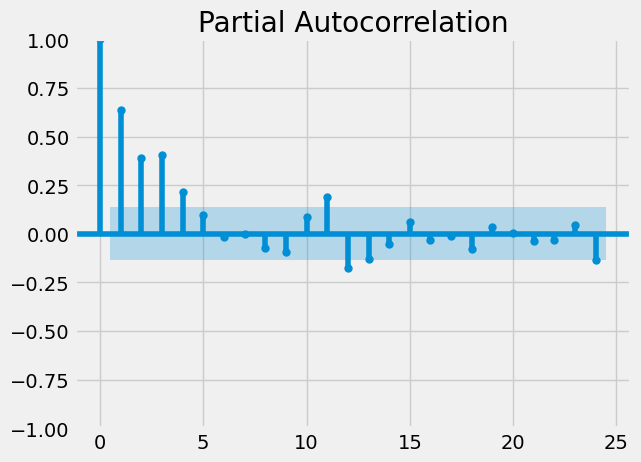

In [26]:
#This code uses the pacf() function from the tsa.stattools module of the statsmodels library (sm) to compute the autocorrelation function.
plot_pacf(outputs['Construction'],method="yw")
#Print the visualization
plt.show()

In [107]:
const_data = outputs[['Month','Construction']]
#Convert the date column to datetime format
const_data["Month"] = pd.to_datetime(const_data["Month"])
train_ml, test_ml, y_train, y_test = train_test_split(const_data, const_data['Construction'], test_size=0.3, random_state=0)

In [108]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['quarter'] = df['Month'].dt.quarter
    df['month'] = df['Month'].dt.month
    df['year'] = df['Month'].dt.year
    df['CPI'] = inputs.iloc[:,2]
    df['InterestRate'] = inputs.iloc[:,3]
    df['GDP'] = inputs.iloc[:,4]
    df['ValAddConst'] = inputs.iloc[:,5]
    df['ValAddInfo'] = inputs.iloc[:,6]
    df['Borrowing'] = inputs.iloc[:,7]
    df['CommercialLoan'] = inputs.iloc[:,8]
    df['ConsumerLoan'] = inputs.iloc[:,9]
    df['Deficit'] = inputs.iloc[:,10]
    df['ITBPrice'] = inputs.iloc[:,11]
    df['ITBVol'] = inputs.iloc[:,12]
    df['VGTPrice'] = inputs.iloc[:,13]
    df['VGTVol'] = inputs.iloc[:,14]
    df['S&P500Price'] = inputs.iloc[:,15]
    df['S&P500Vol'] = inputs.iloc[:,16]
    # X = df[['quarter','month','year']]
    X = df[['quarter','month','year','CPI', 'InterestRate', 'GDP', 'ValAddConst', 'ValAddInfo','Borrowing','CommercialLoan', 'ConsumerLoan','Deficit','ITBPrice', 'ITBVol','VGTPrice', 'VGTVol','S&P500Price','S&P500Vol']]
    # X = df[['month','year','CPI', 'GDP', 'ValAddConst','Borrowing','Deficit','ITBPrice','VGTPrice', 'VGTVol']]
    if label:
        y = df[label]
        return X, y
    return X

In [109]:
#Creating the features for the train and test sets
X_train, y_train = create_features(train_ml, label="Construction")
X_test, y_test = create_features(test_ml, label="Construction")
X_train.head()

,quarter,month,year,CPI,InterestRate,GDP,ValAddConst,ValAddInfo,Borrowing,CommercialLoan,ConsumerLoan,Deficit,ITBPrice,ITBVol,VGTPrice,VGTVol,S&P500Price,S&P500Vol
122,3,8,2016,0.002776,0.026316,0.010009,0.010391,0.007592,-0.003105,0.017,0.075,-1.119069,-0.005865,-0.366216,0.052089,-0.365584,-0.005865,-0.366216
83,2,5,2013,-0.002812,0.071429,0.011152,0.011946,0.019861,-0.008421,0.067,0.008,-0.476611,0.091315,-0.208360,0.057939,0.145666,0.091315,-0.208360
19,1,1,2008,0.007859,-0.055679,0.010401,0.000000,0.015205,0.012270,0.159,0.086,0.728386,-0.096935,1.339128,-0.109206,1.641480,-0.096935,1.339128
154,2,4,2019,0.002390,0.004167,0.008305,0.010688,0.000000,-0.008736,0.030,0.055,-27.947005,0.070572,-0.299372,0.061883,0.293868,0.070572,-0.299372
107,2,5,2015,0.002694,0.090909,0.009456,0.013186,0.014764,0.020628,0.151,0.028,-0.724941,-0.036732,-0.270013,0.017862,-0.183766,-0.036732,-0.270013


In [110]:
X_train['prev1']=train_ml['Construction'].shift(1)
X_test['prev1']=test_ml['Construction'].shift(1)
X_train['prev2'] =train_ml['Construction'].shift(2)
X_test['prev2']=test_ml['Construction'].shift(2)
X_train['prev3'] =train_ml['Construction'].shift(3)
X_test['prev3']=test_ml['Construction'].shift(3)
X_train['prev4'] =train_ml['Construction'].shift(4)
X_test['prev4']=test_ml['Construction'].shift(4)

In [111]:
#Defining and fitting the model
reg = xgb.XGBRegressor(n_estimators=1000,early_stopping_rounds=60,)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
       verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=60,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

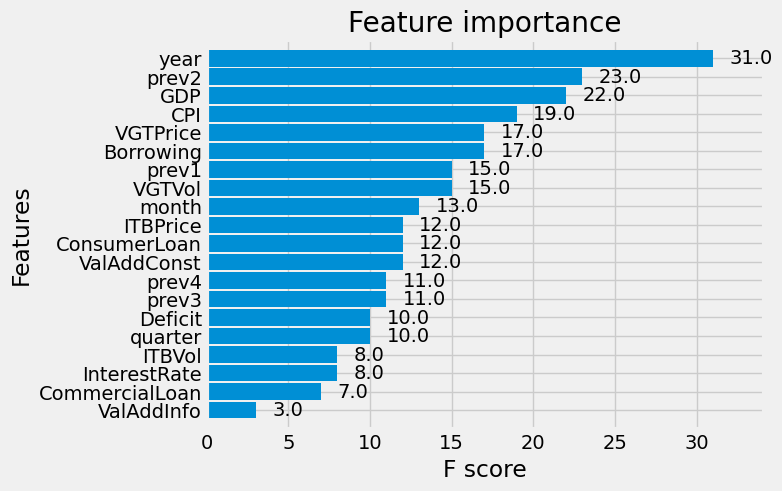

In [112]:
#Plot of feature importance
_ = plot_importance(reg, height=0.9)

In [113]:
#Predicting with our model for both the train and test data
train_ml["Predictions"] = reg.predict(X_train)
test_ml['Prediction'] = reg.predict(X_test)

In [114]:
#Plotting the predictions of the training data
XGBoost_and_rolling = pd.concat([pd.DataFrame(list(train_ml["Predictions"]),list(train_ml["Construction"]))], axis=1).dropna().reset_index()
XGBoost_and_rolling.rename(columns={"index":"Real_Construction",0:"Predicted Construction"}, inplace=True)
XGBoost_and_rolling = px.line(XGBoost_and_rolling, title = 'XGBOOST vs Construction TRAIN', width=1000, height=500)
XGBoost_and_rolling.show()

In [115]:
#Plotting the predictions of the testing data
XGBoost_and_rolling = pd.concat([pd.DataFrame(list(test_ml["Prediction"]),list(test_ml["Construction"]))], axis=1).dropna().reset_index()
XGBoost_and_rolling.rename(columns={"index":"Real_Construction",0:"Predicted Construction"}, inplace=True)
XGBoost_and_rolling = px.line(XGBoost_and_rolling, title = 'XGBOOST vs Construction TEST', width=1000, height=500)
XGBoost_and_rolling.show()

In [116]:
pred_sign = np.sign(train_ml['Predictions'])
y_test_sign = np.sign(train_ml['Construction'])
classification_accuracy = 1 - 0.5*np.sum(np.abs(pred_sign - y_test_sign))/np.size(y_test_sign)
classification_accuracy

0.9859154929577465

In [117]:
pred_sign = np.sign(test_ml['Prediction'])
y_test_sign = np.sign(test_ml['Construction'])
classification_accuracy = 1 - 0.5*np.sum(np.abs(pred_sign - y_test_sign))/np.size(y_test_sign)
classification_accuracy

0.8548387096774194

Metrics:


Root Mean Square Error, RMSE: Square root of the mean of the difference between the actual data points and the squared prediction value. It penalizes greater or extreme differences more.

Mean Absolute Percentage Error, MAPE: It allows to measure errors relative to the magnitude of the real value.

In [118]:
RMSE_Serie_XG = mean_squared_error(train_ml["Construction"],train_ml["Predictions"],squared=False)
MAPE_Serie_XG = mean_absolute_percentage_error(train_ml["Construction"], train_ml["Predictions"])
print(f"The RMSE of our XGBOOST model in the full serie data is {round(RMSE_Serie_XG,4)}")
print(f"The MAPE of our XGBOOST model in the full serie data is {round(MAPE_Serie_XG*100,2)}%")

The RMSE of our XGBOOST model in the full serie data is 0.0005
The MAPE of our XGBOOST model in the full serie data is 21.0%


In [119]:
true_vol = test_ml['Prediction']
pred_vol = test_ml["Construction"]
RMSE_XG = mean_squared_error(true_vol, pred_vol,squared=False)
MAPE_XG = mean_absolute_percentage_error(true_vol, pred_vol)
print(f"The RMSE of our XGBOOST model in the predicted data is {round(RMSE_XG,4)}")
print(f"The MAPE of our XGBOOST model in the predicted data is {round(MAPE_XG*100,2)}%")

The RMSE of our XGBOOST model in the predicted data is 0.0043
The MAPE of our XGBOOST model in the predicted data is 126.73%


In [120]:
X, y = create_features(const_data, label="Construction")
X['prev1'] = const_data['Construction'].shift(1)
X['prev2'] = const_data['Construction'].shift(2)
X['prev3'] = const_data['Construction'].shift(3)
X['prev4'] = const_data['Construction'].shift(4)
const_data["Predictions"] = reg.predict(X)
#Plotting the predictions of the training data
XGBoost_and_rolling = pd.concat([pd.DataFrame(list(const_data["Predictions"]),list(const_data["Construction"]))], axis=1).dropna().reset_index()
XGBoost_and_rolling.rename(columns={"index":"Real_Construction",0:"Predicted Construction"}, inplace=True)
XGBoost_and_rolling = px.line(XGBoost_and_rolling, title = 'XGBOOST vs Construction FULL', width=1000, height=500)
XGBoost_and_rolling.show()

In [121]:
pred_sign = np.sign(const_data['Predictions'])
y_test_sign = np.sign(const_data['Construction'])
classification_accuracy = 1 - 0.5*np.sum(np.abs(pred_sign - y_test_sign))/np.size(y_test_sign)
classification_accuracy

0.8970588235294118

In [122]:
true_vol = const_data['Predictions']
pred_vol = const_data["Construction"]
RMSE_XG = mean_squared_error(true_vol, pred_vol,squared=False)
MAPE_XG = mean_absolute_percentage_error(true_vol, pred_vol)
print(f"The RMSE of our XGBOOST model in the predicted data is {round(RMSE_XG,4)}")
print(f"The MAPE of our XGBOOST model in the predicted data is {round(MAPE_XG*100,2)}%")

The RMSE of our XGBOOST model in the predicted data is 0.0031
The MAPE of our XGBOOST model in the predicted data is 122.28%


# Prediction for Information

In [124]:
fig = px.line(outputs['Information'], width=1000, height=500)
fig.update_layout(title_text='Monthly employment data of Information from 2006-06-01 to 2023-09-01')
fig.show()

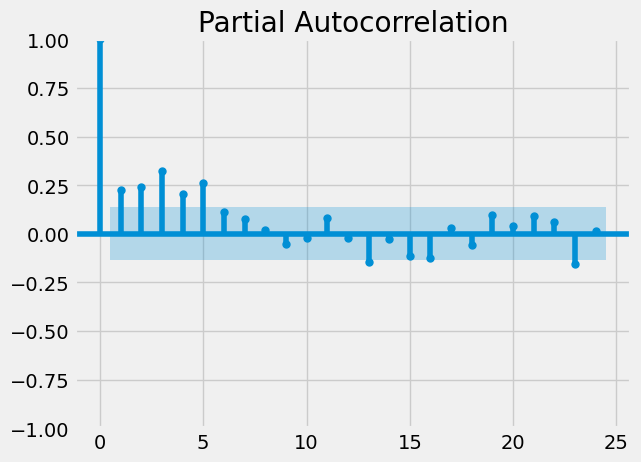

In [125]:
plot_pacf(outputs['Information'],method="yw")
#Print the visualization
plt.show()

In [126]:
info_data = outputs[['Month','Information']]
#Convert the date column to datetime format
info_data["Month"] = pd.to_datetime(info_data["Month"])
train_ml, test_ml, y_train, y_test = train_test_split(info_data, info_data['Information'], test_size=0.3, random_state=0)

In [275]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['quarter'] = df['Month'].dt.quarter
    df['month'] = df['Month'].dt.month
    df['year'] = df['Month'].dt.year
    df['CPI'] = inputs.iloc[:,2]
    df['InterestRate'] = inputs.iloc[:,3]
    df['GDP'] = inputs.iloc[:,4]
    df['ValAddConst'] = inputs.iloc[:,5]
    df['ValAddInfo'] = inputs.iloc[:,6]
    df['Borrowing'] = inputs.iloc[:,7]
    df['CommercialLoan'] = inputs.iloc[:,8]
    df['ConsumerLoan'] = inputs.iloc[:,9]
    df['Deficit'] = inputs.iloc[:,10]
    df['ITBPrice'] = inputs.iloc[:,11]
    df['ITBVol'] = inputs.iloc[:,12]
    df['VGTPrice'] = inputs.iloc[:,13]
    df['VGTVol'] = inputs.iloc[:,14]
    df['S&P500Price'] = inputs.iloc[:,15]
    df['S&P500Vol'] = inputs.iloc[:,16]
    # X = df[['quarter','month','year']]
    # X = df[['quarter','month','year','CPI', 'InterestRate', 'GDP', 'ValAddConst', 'ValAddInfo','Borrowing','CommercialLoan', 'ConsumerLoan','Deficit','ITBPrice', 'ITBVol','VGTPrice', 'VGTVol','S&P500Price','S&P500Vol']]
    # X = df[['quarter','CPI', 'InterestRate','CommercialLoan', 'ConsumerLoan','Deficit','ITBPrice', 'VGTVol','S&P500Price','S&P500Vol']]
    X = df[['quarter','month','year','CPI', 'InterestRate', 'GDP','Borrowing','CommercialLoan', 'ConsumerLoan','Deficit','ITBPrice','VGTPrice','S&P500Price']]
    if label:
        y = df[label]
        return X, y
    return X

In [276]:
#Creating the features for the train and test sets
X_train, y_train = create_features(train_ml, label="Information")
X_test, y_test = create_features(test_ml, label="Information")
X_train.head()

,quarter,month,year,CPI,InterestRate,GDP,Borrowing,CommercialLoan,ConsumerLoan,Deficit,ITBPrice,VGTPrice,S&P500Price
122,3,8,2016,0.002776,0.026316,0.010009,-0.003105,0.017,0.075,-1.119069,-0.005865,0.052089,-0.005865
83,2,5,2013,-0.002812,0.071429,0.011152,-0.008421,0.067,0.008,-0.476611,0.091315,0.057939,0.091315
19,1,1,2008,0.007859,-0.055679,0.010401,0.012270,0.159,0.086,0.728386,-0.096935,-0.109206,-0.096935
154,2,4,2019,0.002390,0.004167,0.008305,-0.008736,0.030,0.055,-27.947005,0.070572,0.061883,0.070572
107,2,5,2015,0.002694,0.090909,0.009456,0.020628,0.151,0.028,-0.724941,-0.036732,0.017862,-0.036732


In [277]:
X_train['prev1']=train_ml['Information'].shift(1)
X_test['prev1']=test_ml['Information'].shift(1)
#X_train['prev2'] =train_ml['Information'].shift(2)
#X_test['prev2']=test_ml['Information'].shift(2)
X_train['prev3'] =train_ml['Information'].shift(3)
X_test['prev3']=test_ml['Information'].shift(3)
#X_train['prev4'] =train_ml['Information'].shift(4)
#X_test['prev4']=test_ml['Information'].shift(4)
X_train['prev5'] =train_ml['Information'].shift(5)
X_test['prev5']=test_ml['Information'].shift(5)

In [278]:
#Defining and fitting the model
reg = xgb.XGBRegressor(n_estimators=1000,early_stopping_rounds=60,)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
       verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=60,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

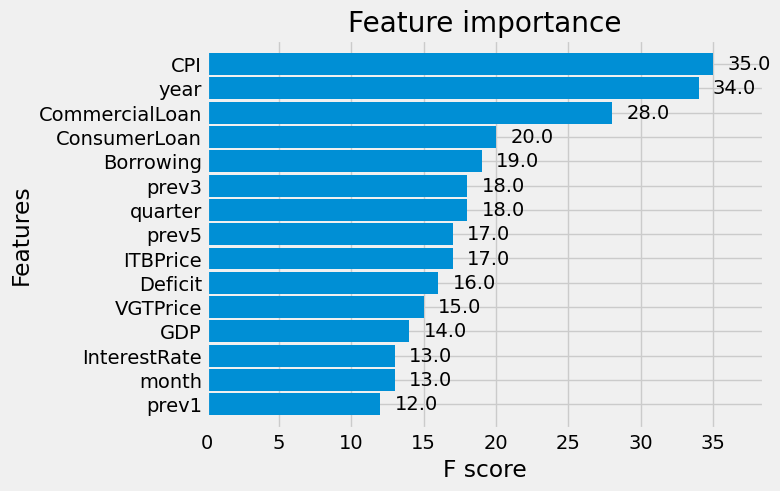

In [279]:
#Plot of feature importance
_ = plot_importance(reg, height=0.9)

In [280]:
#Predicting with our model for both the train and test data
train_ml["Predictions"] = reg.predict(X_train)
test_ml['Prediction'] = reg.predict(X_test)

In [281]:
#Plotting the predictions of the training data
XGBoost_and_rolling = pd.concat([pd.DataFrame(list(train_ml["Predictions"]),list(train_ml["Information"]))], axis=1).dropna().reset_index()
XGBoost_and_rolling.rename(columns={"index":"Real_Information",0:"Predicted Information"}, inplace=True)
XGBoost_and_rolling = px.line(XGBoost_and_rolling, title = 'XGBOOST vs Information TRAIN', width=1000, height=500)
XGBoost_and_rolling.show()

In [282]:
#Plotting the predictions of the testing data
XGBoost_and_rolling = pd.concat([pd.DataFrame(list(test_ml["Prediction"]),list(test_ml["Information"]))], axis=1).dropna().reset_index()
XGBoost_and_rolling.rename(columns={"index":"Real_Information",0:"Predicted Information"}, inplace=True)
XGBoost_and_rolling = px.line(XGBoost_and_rolling, title = 'XGBOOST vs Information TEST', width=1000, height=500)
XGBoost_and_rolling.show()

In [283]:
pred_sign = np.sign(train_ml['Predictions'])
y_test_sign = np.sign(train_ml['Information'])
classification_accuracy = 1 - 0.5*np.sum(np.abs(pred_sign - y_test_sign))/np.size(y_test_sign)
classification_accuracy

0.9753521126760564

In [284]:
pred_sign = np.sign(test_ml['Prediction'])
y_test_sign = np.sign(test_ml['Information'])
classification_accuracy = 1 - 0.5*np.sum(np.abs(pred_sign - y_test_sign))/np.size(y_test_sign)
classification_accuracy

0.685483870967742

In [285]:
RMSE_Serie_XG = mean_squared_error(train_ml["Information"],train_ml["Predictions"],squared=False)
MAPE_Serie_XG = mean_absolute_percentage_error(train_ml["Information"], train_ml["Predictions"])
print(f"The RMSE of our XGBOOST model in the full serie data is {round(RMSE_Serie_XG,4)}")
print(f"The MAPE of our XGBOOST model in the full serie data is {round(MAPE_Serie_XG*100,2)}%")

The RMSE of our XGBOOST model in the full serie data is 0.0009
The MAPE of our XGBOOST model in the full serie data is 2924460557006.26%


In [286]:
true_vol = test_ml['Prediction']
pred_vol = test_ml["Information"]
RMSE_XG = mean_squared_error(true_vol, pred_vol,squared=False)
MAPE_XG = mean_absolute_percentage_error(true_vol, pred_vol)
print(f"The RMSE of our XGBOOST model in the predicted data is {round(RMSE_XG,4)}")
print(f"The MAPE of our XGBOOST model in the predicted data is {round(MAPE_XG*100,2)}%")

The RMSE of our XGBOOST model in the predicted data is 0.0045
The MAPE of our XGBOOST model in the predicted data is 691.29%


In [288]:
X, y = create_features(info_data, label="Information")
X['prev1'] = info_data['Information'].shift(1)
#X['prev2'] = info_data['Information'].shift(2)
X['prev3'] = info_data['Information'].shift(3)
#X['prev4'] = info_data['Information'].shift(4)
X['prev5'] = info_data['Information'].shift(5)
info_data["Predictions"] = reg.predict(X)
#Plotting the predictions of the training data
XGBoost_and_rolling = pd.concat([pd.DataFrame(list(info_data["Predictions"]),list(info_data["Information"]))], axis=1).dropna().reset_index()
XGBoost_and_rolling.rename(columns={"index":"Real_Information",0:"Predicted Information"}, inplace=True)
XGBoost_and_rolling = px.line(XGBoost_and_rolling, title = 'XGBOOST vs Information FULL', width=1000, height=500)
XGBoost_and_rolling.show()

In [289]:
pred_sign = np.sign(info_data['Predictions'])
y_test_sign = np.sign(info_data['Information'])
classification_accuracy = 1 - 0.5*np.sum(np.abs(pred_sign - y_test_sign))/np.size(y_test_sign)
classification_accuracy

0.8235294117647058

In [290]:
true_vol = info_data['Predictions']
pred_vol = info_data["Information"]
RMSE_XG = mean_squared_error(true_vol, pred_vol,squared=False)
MAPE_XG = mean_absolute_percentage_error(true_vol, pred_vol)
print(f"The RMSE of our XGBOOST model in the predicted data is {round(RMSE_XG,4)}")
print(f"The MAPE of our XGBOOST model in the predicted data is {round(MAPE_XG*100,2)}%")

The RMSE of our XGBOOST model in the predicted data is 0.003
The MAPE of our XGBOOST model in the predicted data is 415.36%


# Prediction for Total Private

In [39]:
fig = px.line(outputs['Total_Private'], width=1000, height=500)
fig.update_layout(title_text='Monthly employment data of Total_Private from 2006-06-01 to 2023-09-01')
fig.show()

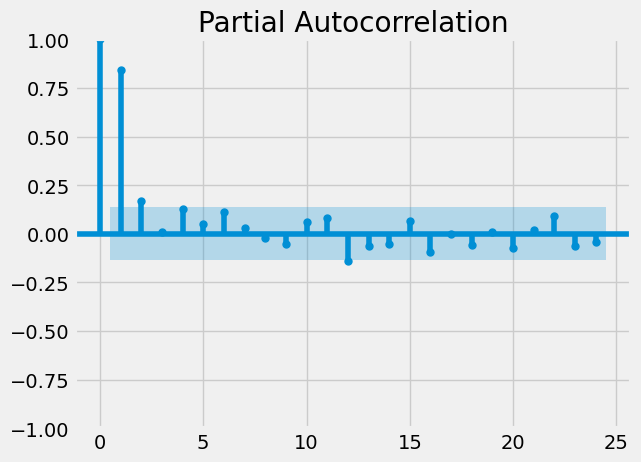

In [40]:
plot_pacf(outputs['Total_Private'],method="yw")
#Print the visualization
plt.show()

In [291]:
totpriv_data = outputs[['Month','Total_Private']]
#Convert the date column to datetime format
totpriv_data["Month"] = pd.to_datetime(totpriv_data["Month"])
train_ml, test_ml, y_train, y_test = train_test_split(totpriv_data, totpriv_data['Total_Private'], test_size=0.3, random_state=0)

In [292]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['quarter'] = df['Month'].dt.quarter
    df['month'] = df['Month'].dt.month
    df['year'] = df['Month'].dt.year
    df['CPI'] = inputs.iloc[:,2]
    df['InterestRate'] = inputs.iloc[:,3]
    df['GDP'] = inputs.iloc[:,4]
    df['ValAddConst'] = inputs.iloc[:,5]
    df['ValAddInfo'] = inputs.iloc[:,6]
    df['Borrowing'] = inputs.iloc[:,7]
    df['CommercialLoan'] = inputs.iloc[:,8]
    df['ConsumerLoan'] = inputs.iloc[:,9]
    df['Deficit'] = inputs.iloc[:,10]
    df['ITBPrice'] = inputs.iloc[:,11]
    df['ITBVol'] = inputs.iloc[:,12]
    df['VGTPrice'] = inputs.iloc[:,13]
    df['VGTVol'] = inputs.iloc[:,14]
    df['S&P500Price'] = inputs.iloc[:,15]
    df['S&P500Vol'] = inputs.iloc[:,16]
    # X = df[['quarter','month','year']]
    X = df[['year','CommercialLoan', 'ConsumerLoan','CPI']]
    # X = df[['quarter','month','year','CPI', 'InterestRate', 'GDP', 'ValAddConst', 'ValAddInfo','Borrowing','CommercialLoan', 'ConsumerLoan','Deficit','ITBPrice', 'ITBVol','VGTPrice', 'VGTVol','S&P500Price','S&P500Vol']]
    if label:
        y = df[label]
        return X, y
    return X

In [293]:
#Creating the features for the train and test sets
X_train, y_train = create_features(train_ml, label="Total_Private")
X_test, y_test = create_features(test_ml, label="Total_Private")
X_train.head()

,year,CommercialLoan,ConsumerLoan,CPI
122,2016,0.017,0.075,0.002776
83,2013,0.067,0.008,-0.002812
19,2008,0.159,0.086,0.007859
154,2019,0.030,0.055,0.002390
107,2015,0.151,0.028,0.002694


In [294]:
X_train['prev1']=train_ml['Total_Private'].shift(1)
X_test['prev1']=test_ml['Total_Private'].shift(1)
X_train['prev2'] =train_ml['Total_Private'].shift(2)
X_test['prev2']=test_ml['Total_Private'].shift(2)

In [295]:
#Defining and fitting the model
reg = xgb.XGBRegressor(n_estimators=1000,early_stopping_rounds=60,)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
       verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=60,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

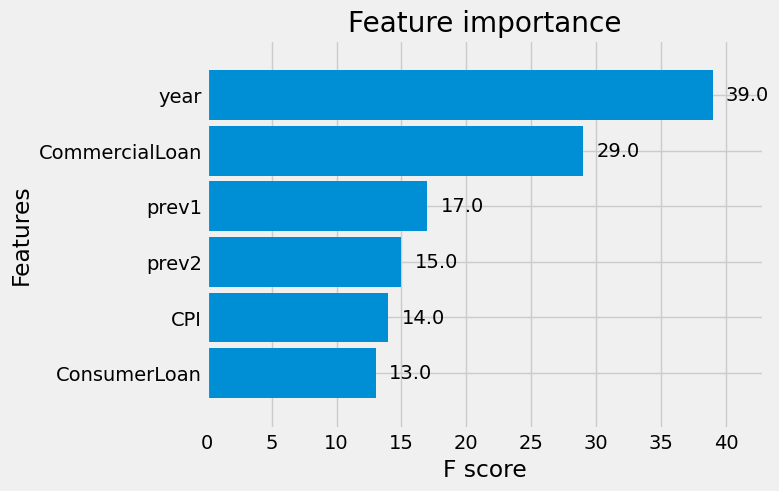

In [296]:
#Plot of feature importance
_ = plot_importance(reg, height=0.9)

In [297]:
#Predicting with our model for both the train and test data
train_ml["Predictions"] = reg.predict(X_train)
test_ml['Prediction'] = reg.predict(X_test)

In [298]:
#Plotting the predictions of the training data
XGBoost_and_rolling = pd.concat([pd.DataFrame(list(train_ml["Predictions"]),list(train_ml["Total_Private"]))], axis=1).dropna().reset_index()
XGBoost_and_rolling.rename(columns={"index":"Real_Total_Private",0:"Predicted Total_Private"}, inplace=True)
XGBoost_and_rolling = px.line(XGBoost_and_rolling, title = 'XGBOOST vs Total_Private TRAIN', width=1000, height=500)
XGBoost_and_rolling.show()

In [299]:
#Plotting the predictions of the testing data
XGBoost_and_rolling = pd.concat([pd.DataFrame(list(test_ml["Prediction"]),list(test_ml["Total_Private"]))], axis=1).dropna().reset_index()
XGBoost_and_rolling.rename(columns={"index":"Real_Total_Private",0:"Predicted Total_Private"}, inplace=True)
XGBoost_and_rolling = px.line(XGBoost_and_rolling, title = 'XGBOOST vs Total_Private TEST', width=1000, height=500)
XGBoost_and_rolling.show()

In [300]:
pred_sign = np.sign(train_ml['Predictions'])
y_test_sign = np.sign(train_ml['Total_Private'])
classification_accuracy = 1 - 0.5*np.sum(np.abs(pred_sign - y_test_sign))/np.size(y_test_sign)
classification_accuracy

0.9788732394366197

In [301]:
pred_sign = np.sign(test_ml['Prediction'])
y_test_sign = np.sign(test_ml['Total_Private'])
classification_accuracy = 1 - 0.5*np.sum(np.abs(pred_sign - y_test_sign))/np.size(y_test_sign)
classification_accuracy

0.9838709677419355

In [302]:
RMSE_Serie_XG = mean_squared_error(train_ml["Total_Private"],train_ml["Predictions"],squared=False)
MAPE_Serie_XG = mean_absolute_percentage_error(train_ml["Total_Private"], train_ml["Predictions"])
print(f"The RMSE of our XGBOOST model in the full serie data is {round(RMSE_Serie_XG,4)}")
print(f"The MAPE of our XGBOOST model in the full serie data is {round(MAPE_Serie_XG*100,2)}%")

The RMSE of our XGBOOST model in the full serie data is 0.0005
The MAPE of our XGBOOST model in the full serie data is 43.83%


In [303]:
true_vol = test_ml['Prediction']
pred_vol = test_ml["Total_Private"]
RMSE_XG = mean_squared_error(true_vol, pred_vol,squared=False)
MAPE_XG = mean_absolute_percentage_error(true_vol, pred_vol)
print(f"The RMSE of our XGBOOST model in the predicted data is {round(RMSE_XG,4)}")
print(f"The MAPE of our XGBOOST model in the predicted data is {round(MAPE_XG*100,2)}%")

The RMSE of our XGBOOST model in the predicted data is 0.0017
The MAPE of our XGBOOST model in the predicted data is 64.9%


In [304]:
X, y = create_features(totpriv_data, label="Total_Private")
X['prev1'] = totpriv_data['Total_Private'].shift(1)
X['prev2'] = totpriv_data['Total_Private'].shift(2)
totpriv_data["Predictions"] = reg.predict(X)
#Plotting the predictions of the training data
XGBoost_and_rolling = pd.concat([pd.DataFrame(list(totpriv_data["Predictions"]),list(totpriv_data["Total_Private"]))], axis=1).dropna().reset_index()
XGBoost_and_rolling.rename(columns={"index":"Real_Total_Private",0:"Predicted Total_Private"}, inplace=True)
XGBoost_and_rolling = px.line(XGBoost_and_rolling, title = 'XGBOOST vs Total_Private FULL', width=1000, height=500)
XGBoost_and_rolling.show()

In [305]:
pred_sign = np.sign(totpriv_data['Predictions'])
y_test_sign = np.sign(totpriv_data['Total_Private'])
classification_accuracy = 1 - 0.5*np.sum(np.abs(pred_sign - y_test_sign))/np.size(y_test_sign)
classification_accuracy

0.9803921568627451

In [306]:
true_vol = totpriv_data['Predictions']
pred_vol = totpriv_data["Total_Private"]
RMSE_XG = mean_squared_error(true_vol, pred_vol,squared=False)
MAPE_XG = mean_absolute_percentage_error(true_vol, pred_vol)
print(f"The RMSE of our XGBOOST model in the predicted data is {round(RMSE_XG,4)}")
print(f"The MAPE of our XGBOOST model in the predicted data is {round(MAPE_XG*100,2)}%")

The RMSE of our XGBOOST model in the predicted data is 0.0015
The MAPE of our XGBOOST model in the predicted data is 55.47%
